# Homework: Word Embedding

In this exercise, you will work on the skip-gram neural network architecture for Word2Vec. You will be using Keras to train your model. 

You must complete the following tasks:
1. Read/clean text files
2. Indexing (Assign a number to each word)
3. Create skip-grams (inputs for your model)
4. Create the skip-gram neural network model
5. Visualization
6. Evaluation (Using pre-trained, not using pre-trained)  
    (classify topic from 4 categories) 
    
This notebook assumes you have already installed Tensorflow and Keras with python3 and had GPU enabled. If you run this exercise on GCloud using the provided disk image you are all set.



In [25]:
# %tensorflow_version 2.x
%matplotlib inline
import numpy as np
import pandas as pd
import math
import glob
import re
import random
import collections
import os
import sys
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dropout
from keras.models import load_model
from keras.layers import Embedding, Reshape, Activation, Input, Dense, Masking, Conv1D, Bidirectional
from tensorflow.python.keras.layers.merge import Dot
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence
from keras import backend as K
from keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.font_manager.fontManager.addfont('../../font/THSarabunNew.ttf')
mpl.rc('font', family='TH Sarabun New')

random.seed(42)

# Step 1: Read/clean text files

The given code can be used to processed the pre-tokenzied text file from the wikipedia corpus. In your homework, you must replace those text files with raw text files.  You must use your own tokenizer to process your text files

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import shutil
# shutil.copy("/content/drive/MyDrive/FRA 501 IntroNLP&DL/Dataset/wiki.zip","/content/wiki.zip")
# shutil.copy("/content/drive/MyDrive/FRA 501 IntroNLP&DL/Dataset/BEST-TrainingSet.zip","/content/BEST-TrainingSet.zip")

In [4]:
# !unzip wiki.zip
# !unzip BEST-TrainingSet.zip

In [5]:
#Step 1: read the wikipedia text file
with open("content/unzipped/wiki/thwiki_chk.txt") as f:
    #the delimiter is one or more whitespace characters
    input_text = re.compile(r"\s+").split(f.read()) 
    #exclude an empty string from our input
    input_text = [word for word in input_text if word != ''] 

In [6]:
tokens = input_text
print(tokens[:10])
print("total word count:", len(tokens))

['หน้า', 'หลัก', 'วิกิพีเดีย', 'ดำเนินการ', 'โดย', 'มูลนิธิ', 'วิกิ', 'มีเดีย', 'องค์กร', 'ไม่']
total word count: 36349066


# Step 2: Indexing (Assign a number to each word)

The code below generates an indexed dataset(each word is represented by a number), a dictionary, a reversed dictionary

## <font color='salmon'>Homework Question 1:</font>
<font color='salmon'>“UNK” is often used to represent an unknown word (a word which does not exist in your dictionary/training set). You can also represent a rare word with this token as well.  How do you define a rare word in your program? Explain in your own words and capture the screenshot of your code segment that is a part of this process</font>

 + <font color='salmon'>edit or replace create_index with your own code to set a threshold for rare words and replace them with "UNK"</font>


### **QUESTION 1 ANSWER:**

![Question 1 Code](https://github.com/AthimetA/FRA501_Introduction_To_Natural_Language_Processing_With_Deep_Learning/blob/main/pic/hw2-2/qn1-code1.png?raw=true)

From the picture, the first line of code will give us a descending list of unique words sorted by frequency of the word.

This means that if we make a loop that scans through the list, we will be able find the index of the first unique word with the frequency less than or equals to the minimum threshold for unknown words (min_thres_unk) then break the loop right away after getting the index of the first unique word.

After that, we will remove all the unique words with frequency less than or equals to the minimum threshold for unknown words by slicing the list with the index of the first unique word.



In [7]:
#step 2:Build dictionary and build a dataset(replace each word with its index)
def create_index(input_text, min_thres_unk = 1, max_word_count = None, debug=False):
    # TODO#1 : edit or replace this function
    debugprint = print if debug else lambda *a, **k: None
    words = [word for word in input_text]
    debugprint("total word count:", len(words))
    word_count = list()
    
    #use set and len to get the number of unique words
    word_count.extend(collections.Counter(words).most_common(len(set(words))))
    # print("number of words with frequency less than", min_thres_unk, ":", len(minkeys))
    for word in word_count:
        if word[1] <= min_thres_unk:
            first_index = word_count.index(word)
            debugprint(f"first index of word with frequency less than {min_thres_unk} is {first_index}")
            debugprint(f"length of word_count is {len(word_count)}")
            break
    word_count = word_count[:first_index]
    #include a token for unknown word
    word_count.append(("UNK", len(words) - sum([word[1] for word in word_count])))
    debugprint("total unique word count:", len(word_count))
    debugprint("total word count after removing words with frequency less than or equal to", min_thres_unk, ":", sum([word[1] for word in word_count]) - word_count[-1][1])

    dictionary = dict()
    dictionary["for_keras_zero_padding"] = 0
    for word in word_count:
        dictionary[word[0]] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    data = list()
    for word in input_text:
        if word in dictionary:
            data.append(dictionary[word])
    
    #print out 10 most frequent words
    debugprint("first 10 words", word_count[:10])
    debugprint("last 10 words", word_count[-10:])
    debugprint("total unique word count:", len(word_count))
    # with open("word_count.txt", "w") as f:
    #     f.write(str(word_count))

    return data, dictionary, reverse_dictionary

In [8]:
# call method with min_thres_unk=1ß
dataset, dictionary, reverse_dictionary = create_index(tokens, 1)
print(len(dataset))
print(len(dictionary))

35942874
295164


In [9]:
print("output sample (dataset):",dataset[:10])
print("output sample (dictionary):",{k: dictionary[k] for k in list(dictionary)[:10]})
print("output sample (reverse dictionary):",{k: reverse_dictionary[k] for k in list(reverse_dictionary)[:10]})

output sample (dataset): [229, 208, 2453, 573, 15, 1829, 7149, 3124, 681, 24]
output sample (dictionary): {'for_keras_zero_padding': 0, 'ที่': 1, 'ใน': 2, 'เป็น': 3, 'และ': 4, 'การ': 5, 'มี': 6, 'ของ': 7, 'ได้': 8, ')': 9}
output sample (reverse dictionary): {0: 'for_keras_zero_padding', 1: 'ที่', 2: 'ใน', 3: 'เป็น', 4: 'และ', 5: 'การ', 6: 'มี', 7: 'ของ', 8: 'ได้', 9: ')'}


In [10]:
with open("debug_dictionary.txt", "w") as f:
    f.write(str(dictionary))

with open("debug_reverse_dictionary.txt", "w") as f:
    f.write(str(reverse_dictionary))

# Step3: Create skip-grams (inputs for your model)
Keras has a skipgrams-generator, the cell below shows us how it generates skipgrams 

## <font color='salmon'>Homework Question 2:</font>
<font color='salmon'>The negative samples are sampled from sampling_table.  Look through Keras source code to find out how they sample negative samples. Discuss the sampling technique taught in class and compare it to the Keras source code.</font>



<font color='red'>**ANS Q2:**</font>  
In class, we learned that negative sampling is when we sample words that is not one of the context words for our target word from the whole vocabulary dictionary (list of words) that we have. The way we sample it is by using probabilities of the appearance of the words in a sentence, the lower the probability is the better negative sample it is.

From Keras source code, we uses the function "make_sampling_table" to generate the sampling argument for skipgram with the same idea as what we learned in class, **more common words should be sampled less frequently.** We uses this function as a parameter inside of "skipgram" function called "sampling_table".

In [11]:
# Step 3: Create data samples
vocab_size = len(dictionary)
skip_window = 1       # How many words to consider left and right.

# TODO#2 check out keras source code and find out how their sampling technique works. Describe it in your own words.
sample_set= dataset[:10]
sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(sample_set, vocab_size, window_size=skip_window, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples, labels)

for i in range(8):
    print(reverse_dictionary[couples[i][0]],reverse_dictionary[couples[i][1]])



[[208, 83708], [208, 2453], [2453, 573], [208, 235515], [24, 681], [2453, 208], [3124, 145853], [2453, 115575], [24, 3408], [208, 229], [3124, 681], [3124, 7149], [3124, 285707], [2453, 219950]] [0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0]
หลัก Merlin
หลัก วิกิพีเดีย
วิกิพีเดีย ดำเนินการ
หลัก LaVoie
ไม่ องค์กร
วิกิพีเดีย หลัก
มีเดีย -House
วิกิพีเดีย (หงส์ทอง


# Step 4: create the skip-gram model
## <font color='salmon'>Homework Question 3:</font>
 <font color='salmon'>Q3:  In your own words, discuss why Sigmoid is chosen as the activation function in the  skip-gram model.</font>

<font color='red'>**ANS Q3:**</font>  
The skip-gram model predicts the probability of each context words. Therefore, the output is in between 0 and 1 and since Sigmoid activation function's range of answer is in between 0 and 1, this means that Sigmoid fits perfectly as the activation function for the skip-gram model.

In [12]:
#reference: https://github.com/nzw0301/keras-examples/blob/master/Skip-gram-with-NS.ipynb
dim_embedddings = 32
V= len(dictionary)

#step1: select the embedding of the target word from W
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V+1, dim_embedddings)(w_inputs)

#step2: select the embedding of the context word from C
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V+1, dim_embedddings)(c_inputs)

#step3: compute the dot product:c_k*v_j
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)

#step4: normailize dot products into probability
o = Activation('sigmoid')(o)
#TO DO#4 Question: Why sigmoid?

SkipGram = Model(inputs=[w_inputs, c_inputs], outputs=o)
SkipGram.summary()
opt=Adam(lr=0.01)
SkipGram.compile(loss='binary_crossentropy', optimizer=opt)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 32)        9445280     ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 32)        9445280     ['input_1[0][0]']                
                                                                                              

c:\Users\omzlette\miniconda3\envs\nlp\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
# # you don't have to spend too much time training for your homework, you are allowed to do it on a smaller corpus
# # currently the dataset is 1/20 of the full text file.
# for _ in range(5):
#     prev_i=0
#     #it is likely that your GPU won't be able to handle large input
#     #just do it 100000 words at a time
#     for i in range(len(dataset)//100000):
#         #generate skipgrams
#         data, labels = skipgrams(sequence=dataset[prev_i*100000:(i*100000)+100000], vocabulary_size=V, window_size=2, negative_samples=4.)
#         x = [np.array(x) for x in zip(*data)]
#         y = np.array(labels, dtype=np.int32)
#         if x:
#             loss = SkipGram.train_on_batch(x, y)
#         prev_i = i 
#         print(loss,i*100000)


In [14]:
# SkipGram.save_weights('hw2_2_skipgram_weight.h5')

In [15]:
#Get weight of the embedding layer
SkipGram.load_weights('hw2_2_skipgram_weight.h5')
final_embeddings=SkipGram.get_weights()[0]
print(final_embeddings)
print(final_embeddings.shape)

[[ 0.02942849 -0.01651738  0.00090514 ... -0.0396731  -0.00961649
   0.0410727 ]
 [ 0.7198411   0.7680737  -0.78755    ... -0.7289395   0.7654709
  -0.7568815 ]
 [ 0.7776858   0.6873883  -0.73114496 ... -0.7483812   0.78560984
  -0.8015211 ]
 ...
 [-0.5841268  -0.66552055  0.6502833  ...  0.69298637 -0.6493391
   0.6393718 ]
 [-0.59900445 -0.6754135   0.5988361  ...  0.6239907  -0.6370992
   0.64077324]
 [ 0.1091732   0.16109465 -0.19907406 ... -0.200748    0.23554419
  -0.25209388]]
(295165, 32)


# Step 5: Intrinsic Evaluation: Word Vector Analogies
## <font color='salmon'>Homework Question 4: </font>
<font color='salmon'> Read section 2.1 and 2.3 in this [lecture note](http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes02-wordvecs2.pdf). Come up with 10 semantic analogy examples and report results produced by your word embeddings. Discuss t-SNE in 2 dimensions. </font>


In [19]:
def plot_with_labels(low_dim_embs, labels, filename=None):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(15, 15))  # in inches
    plt.axis('off')
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
 
    plt.show()
    if filename is not None:
        plt.savefig(filename)

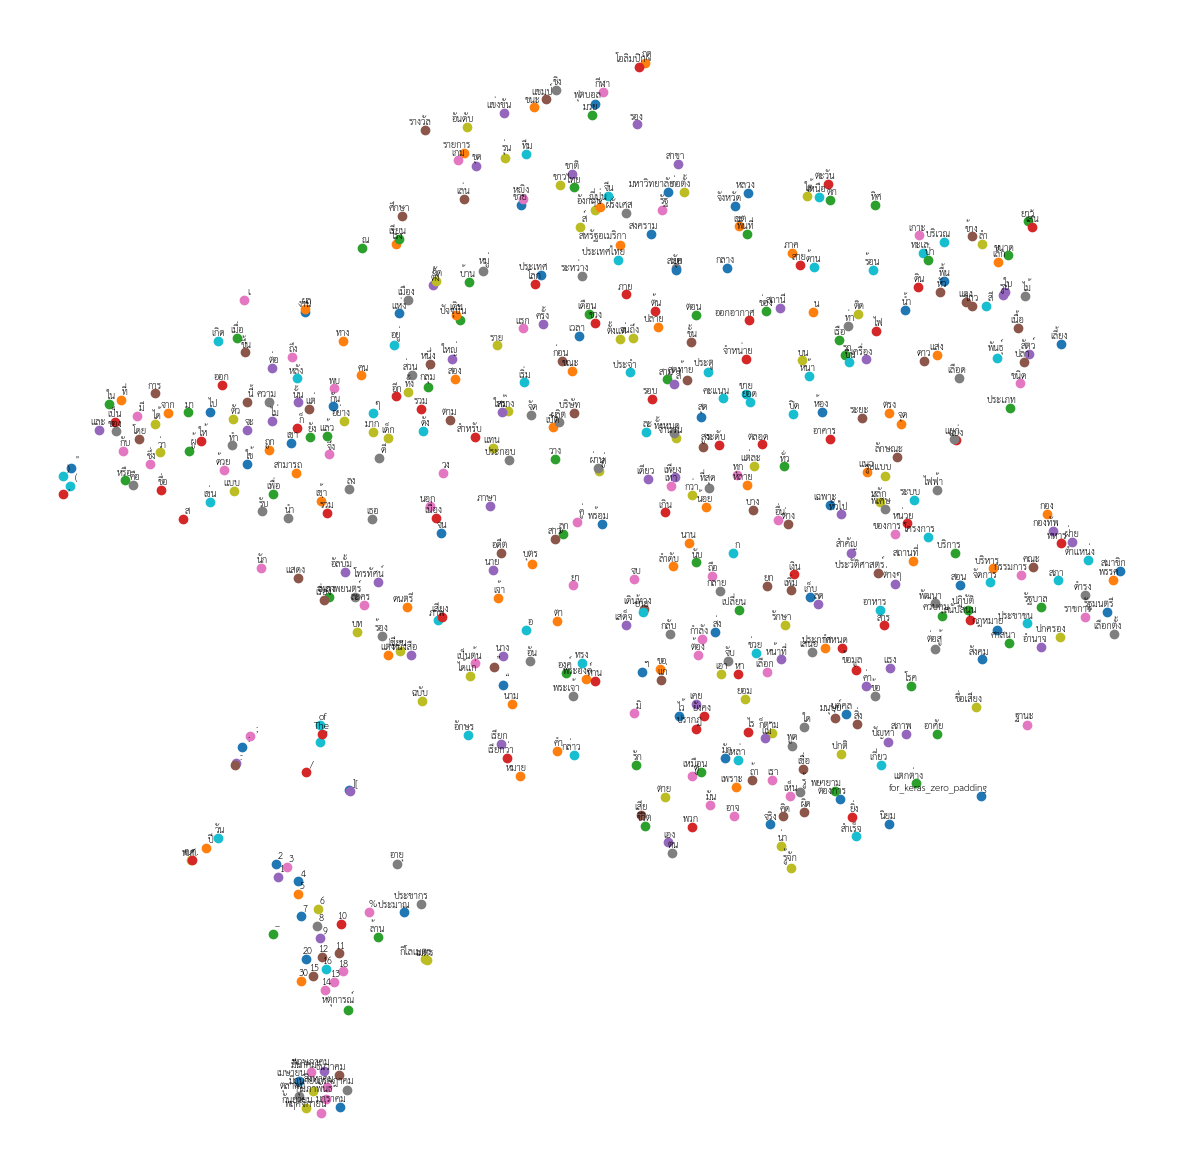

In [24]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500)
plot_only = 500 #only top 500 words
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

In [26]:
tsne2 = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 10000#only top 10000 words
low_dim_embs2 = tsne2.fit_transform(final_embeddings[:plot_only, :])

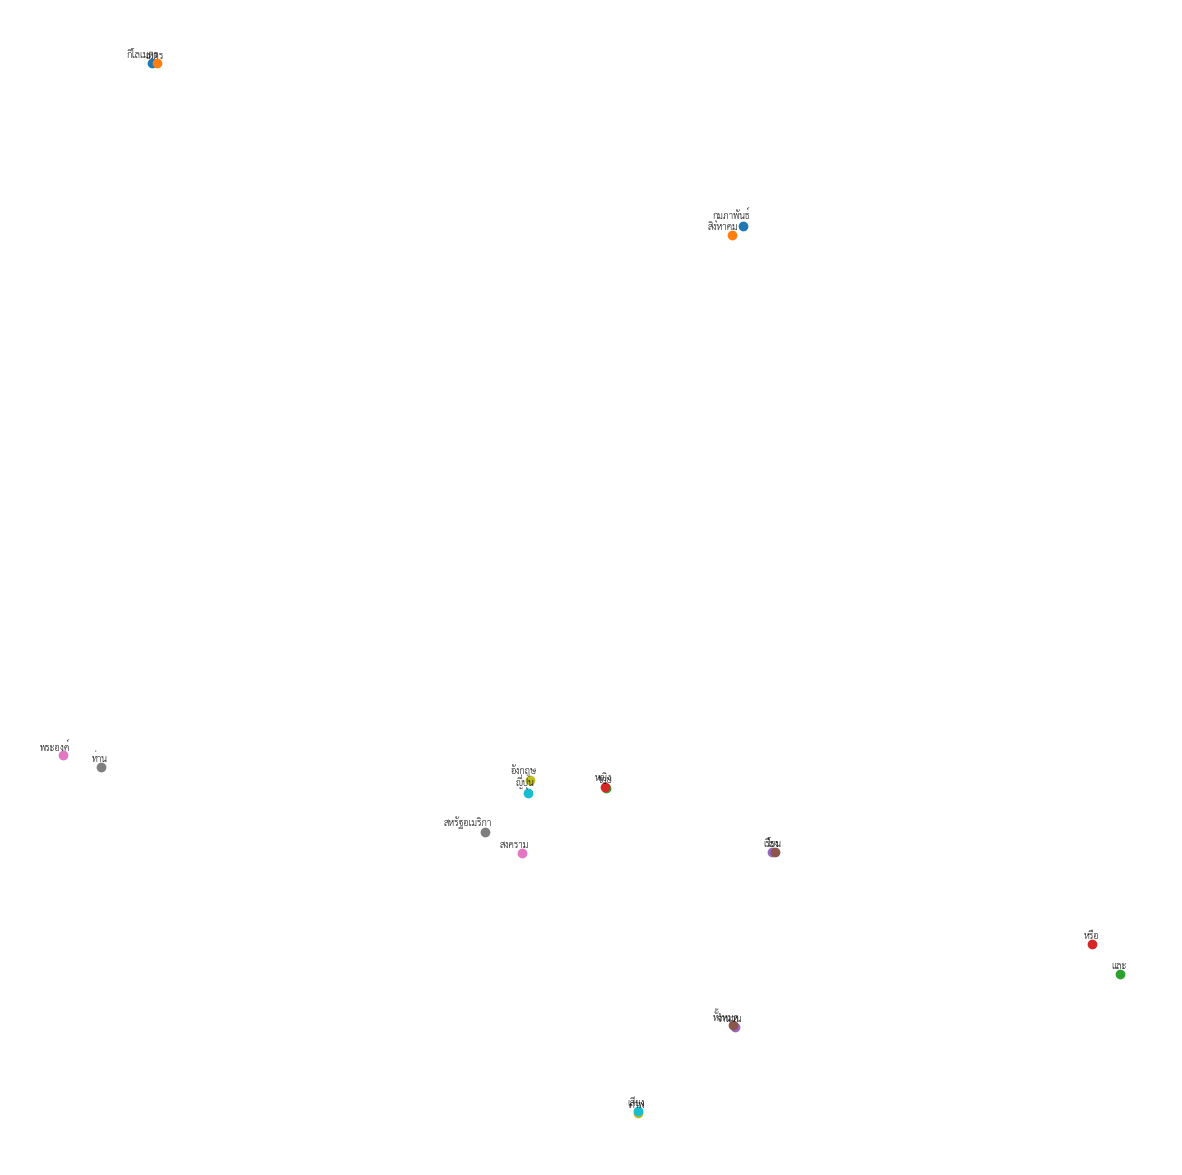

<Figure size 640x480 with 0 Axes>

In [36]:
labels = [reverse_dictionary[i] for i in range(plot_only)]
word_list = ['กุมภาพันธ์', 'สิงหาคม',
             'และ', 'หรือ',
             'โรง', 'เรียน',
             'สงคราม', 'สหรัฐอเมริกา',
             'อังกฤษ', 'ญี่ปุ่น',
             'กิโลเมตร', 'เมตร',
             'ชาย', 'หญิง',
             'จำนวน', 'ทั้งหมด',
             'พระองค์', 'ท่าน',
             'ภาพ', 'เสียง']
idx_list = []
for word in word_list:
    idx_list.append(labels.index(word))
word_plot = low_dim_embs2[idx_list]
plot_with_labels(word_plot,word_list,filename="queen_king.png")

From the above plot, we can observe the 10 semantic analogy examples of this data.
Top-Bottom, Left-Right
|Word 1|Word 2|Reason|
|-|-|-|
|กิโลเมตร|เมตร|Because they are the types of length measurement in Thai (Kilometer & Meter).|
|กุมภาพันธ์|สิงหาคม|Because they are the month name of the year in Thai (Febuary & August).|
|พระองต์|ท่าน|Because พระองค์ can be considered as a way to call the royalty and ท่าน is also a way to call someone, so they are somewhat related to each other as a mean to call someone (His/Her Majesty & Sir).|
|อังกฤษ|ญี่ปุ่น|Because they are countries which had an alliance (Anglo-Japanese Alliance, พันธมิตรอังกฤษ-ญี่ปุ่น) with each other (England & Japan).|
|ชาย|หญิง|Because they are the biological genders (Male & Female).|
|สหรัฐอเมริกา|สงคราม|Because the United States of America (สหรัฐอเมริกา) often get involved in a war (สงคราม).|
|โรง|เรียน|Because these 2 words combined means School (โรงเรียน).|
|หรือ|และ|Because they are the conjunction of sentences (or & and).|
|จำนวน|ทั้งหมด|Because they are quantifiers (Amount & All/Total) and sometimes they are used together like จำนวนทั้งหมด (In total of...).|
|ภาพ|เสียง|Because they are the media used in communications (Picture/Image & Sound).|

# Step 6: Extrinsic Evaluation

## <font color='salmon'>Homework Question 5:</font>
<font color='salmon'>
Use the word embeddings from the skip-gram model as pre-trained weights (GloVe and fastText) in a classification model. Compare the result the with the same classification model that does not use the pre-trained weights. 
</font>


In [ ]:
all_news_filepath = glob.glob('BEST-TrainingSet/news/*.txt')
all_novel_filepath = glob.glob('BEST-TrainingSet/novel/*.txt')
all_article_filepath = glob.glob('BEST-TrainingSet/article/*.txt')
all_encyclopedia_filepath = glob.glob('BEST-TrainingSet/encyclopedia/*.txt')

In [ ]:
#preparing data for the classificaiton model
#In your homework, we will only use the first 2000 words in each text file
#any text file that has less than 2000 words will be padded
#reason:just to make this homework feasible under limited time and resource
max_length = 2000
def word_to_index(word):
    if word in dictionary:
        return dictionary[word]
    else:#if unknown
        return dictionary["UNK"]


def prep_data():
    input_text = list()
    for textfile_path in [all_news_filepath, all_novel_filepath, all_article_filepath, all_encyclopedia_filepath]:
        for input_file in textfile_path:
            f = open(input_file,"r") #open file with name of "*.txt"
            text = re.sub(r'\|', ' ', f.read()) # replace separation symbol with white space           
            text = re.sub(r'<\W?\w+>', '', text)# remove <NE> </NE> <AB> </AB> tags
            text = text.split() #split() method without an argument splits on whitespace 
            indexed_text = list(map(lambda x:word_to_index(x), text[:max_length])) #map raw word string to its index   
            if 'news' in input_file:
                input_text.append([indexed_text,0]) 
            elif 'novel' in input_file:
                input_text.append([indexed_text,1]) 
            elif 'article' in input_file:
                input_text.append([indexed_text,2]) 
            elif 'encyclopedia' in input_file:
                input_text.append([indexed_text,3]) 
            
            f.close()
    random.shuffle(input_text)
    return input_text

input_data = prep_data()
train_data = input_data[:int(len(input_data)*0.6)]
val_data = input_data[int(len(input_data)*0.6):int(len(input_data)*0.8)]
test_data = input_data[int(len(input_data)*0.8):]

train_input = [data[0] for data in train_data]
train_input = sequence.pad_sequences(train_input, maxlen=max_length) #padding
train_target = [data[1] for data in train_data]
train_target=to_categorical(train_target, num_classes=4)

val_input = [data[0] for data in val_data]
val_input = sequence.pad_sequences(val_input, maxlen=max_length) #padding
val_target = [data[1] for data in val_data]
val_target=to_categorical(val_target, num_classes=4)

test_input = [data[0] for data in test_data]
test_input = sequence.pad_sequences(test_input, maxlen=max_length) #padding
test_target = [data[1] for data in test_data]
test_target=to_categorical(test_target, num_classes=4)

del input_data, val_data,train_data, test_data

In [ ]:
#the classification model
#TODO#5 find out how to initialize your embedding layer with pre-trained weights, evaluate and observe
#don't forget to compare it with the same model that does not use pre-trained weights
#you can use your own model too! and feel free to customize this model as you wish
# more information --> https://keras.io/examples/nlp/pretrained_word_embeddings/
# fastText --> https://fasttext.cc/docs/en/crawl-vectors.html (optional)
# !wget --no-check-certificate https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

cls_model = Sequential()
cls_model.add(Embedding(len(dictionary)+1, 32, input_length=max_length,mask_zero=True)) 
cls_model.add(GRU(32))
cls_model.add(Dropout(0.5))
cls_model.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model.summary()
print('Train...')
cls_model.fit(train_input, train_target,
          epochs=10,
          validation_data=[val_input, val_target])

In [ ]:
results = cls_model.evaluate(test_input, test_target)
print("test loss, test acc:", results)